#Libraries and Imports

In [ ]:
!python -m spacy download en_core_web_md
!pip install mord

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=ef69ff676a5cad7f84c07ccd6bd20d0d2fccfbe939c20e2fb79686c9b5a3c4c0
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
import os
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load [syntethic for now] data

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
num_samples = 20

# Load SpaCy's medium model with word vectors
nlp = spacy.load("en_core_web_md")

# Generate fake data
data = {
    "page_title": [f"Page {i}" for i in range(num_samples)],
    "keyword_density": np.random.uniform(0.5, 5.0, num_samples),  # Percentage of keywords in content
    "readability_score": np.random.uniform(30, 90, num_samples),  # Flesch-Kincaid readability score
    "page_speed": np.random.uniform(1, 5, num_samples),  # Load time in seconds
    "mobile_friendly": np.random.choice([0, 1], num_samples),  # 0 = No, 1 = Yes
    "structured_data": np.random.choice([0, 1], num_samples),  # 0 = No, 1 = Yes
    "bounce_rate": np.random.uniform(10, 90, num_samples),  # Percentage of users leaving quickly
    "time_on_page": np.random.uniform(10, 300, num_samples),  # Time in seconds
    "ctr": np.random.uniform(0.01, 0.3, num_samples),  # Click-through rate
    "backlinks": np.random.randint(0, 1000, num_samples),  # Number of backlinks
    "serp_rank": np.random.randint(1, 100, num_samples),  # SERP rank position
    "target_search": 'Best universities'  # SERP rank position
}

# Convert to DataFrame
serp_df = pd.DataFrame(data)

# Function to fetch real HTML content from a URL (fallback to fake content if unavailable)
def get_real_html(url):
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            return response.text
    except:
        pass
    return None

# Function to generate a fake HTML document
def generate_fake_html(title, keyword_density):
    keywords = "SEO, ranking, Google, search engine, optimization, content"
    num_keywords = int(keyword_density * 10)  # Approximate keyword occurrences

    content = " ".join(["This is a sample content about SEO."] * 50)  # Base content
    content += " " + (" ".join([keywords] * num_keywords))  # Injected keywords

    html = f"""
    <html>
    <head>
        <title>{title}</title>
        <meta name="description" content="This is an SEO optimized page about ranking on Google.">
    </head>
    <body>
        <h1>{title}</h1>
        <p>{content}</p>
    </body>
    </html>
    """
    return html

# URLs for real-world web pages (sample SEO-related pages)
real_urls = [
    "https://moz.com/learn/seo/what-is-seo",
    "https://backlinko.com/hub/seo",
    "https://searchengineland.com/guide/what-is-seo",
    "https://www.searchenginejournal.com/seo/",
    "https://www.wordstream.com/seo"
]

# Assign HTML content (real or fake)
serp_df["html_content"] = serp_df.index.map(lambda i: get_real_html(real_urls[i % len(real_urls)]) or generate_fake_html(serp_df.loc[i, "page_title"], serp_df.loc[i, "keyword_density"]))



#Preparing dataset

Add more features.

* Note: target_search may be something that should be removed from the embeddings

In [ ]:
# Extract additional features from HTML using BeautifulSoup
def extract_features_from_html(html):
    soup = BeautifulSoup(html, "html.parser")

    # Meta description length
    meta_desc = soup.find("meta", attrs={"name": "description"})
    meta_desc_length = len(meta_desc["content"]) if meta_desc else 0

    # Number of header tags
    num_headers = len(soup.find_all(["h1", "h2", "h3", "h4", "h5", "h6"]))

    # Number of paragraphs
    num_paragraphs = len(soup.find_all("p"))

    # Word count
    word_count = len(soup.get_text().split())

    # Number of links
    num_links = len(soup.find_all("a"))

    return meta_desc_length, word_count, num_links, num_headers, num_paragraphs

# Apply feature extraction
serp_df[["meta_desc_length", "word_count", "num_links", "num_headers", "num_paragraphs"]] = serp_df["html_content"].apply(
    lambda html: pd.Series(extract_features_from_html(html))
)

# Function to extract embeddings from page content using SpaCy
def extract_spacy_embedding(html):
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text()  # Extract visible text from HTML
    doc = nlp(text)  # Process text with SpaCy
    return doc.vector.tolist()  # Convert to list for storage

# Apply SpaCy embedding extraction to HTML content
serp_df["spacy_embedding"] = serp_df["html_content"].apply(extract_spacy_embedding)

# Display the dataset
print(serp_df.head())

  page_title  keyword_density  readability_score  page_speed  mobile_friendly  \
0     Page 0         2.185431          66.711174    1.488153                1   
1     Page 1         4.778214          38.369632    2.980708                0   
2     Page 2         3.793973          47.528679    1.137554                1   
3     Page 3         3.193963          51.981711    4.637282                0   
4     Page 4         1.202084          57.364199    2.035120                0   

   structured_data  bounce_rate  time_on_page       ctr  backlinks  serp_rank  \
0                1    79.048274     19.114464  0.244158        563         97   
1                0    59.863850    194.559019  0.269866        267          1   
2                1    36.471842    101.163235  0.102221        509         19   
3                1    15.084668    157.485500  0.041915        806          2   
4                1    34.878586    273.194277  0.076101        385         53   

       target_search      

# Model Selection

SERP rankings depend on multiple factors like CTR, backlinks, bounce rate, content quality, etc.

We could assume that

`Ranking Score=α⋅(CTR)+β⋅(Backlinks)−γ⋅(Bounce Rate)−δ⋅(Page Speed)+ϵ⋅(Mobile Friendliness)+...(brand)+(important ones)`

Where α, β, γ, δ are weights that define each feature's importance.



A correlation analysis helps us understand:
* Which features are strongly related to the ranking (positive or negative).
* Which features have little to no impact, so we can exclude them.

## Correlation analysis


Goals:

* Focus on impactful features.
* Simplify the model.
* Assign feature importance weights intelligently.

####Compute correlation matrix

* Pearson measures linear relationships
* Spearman captures increasing/decreasing trends (monotonic relationships).

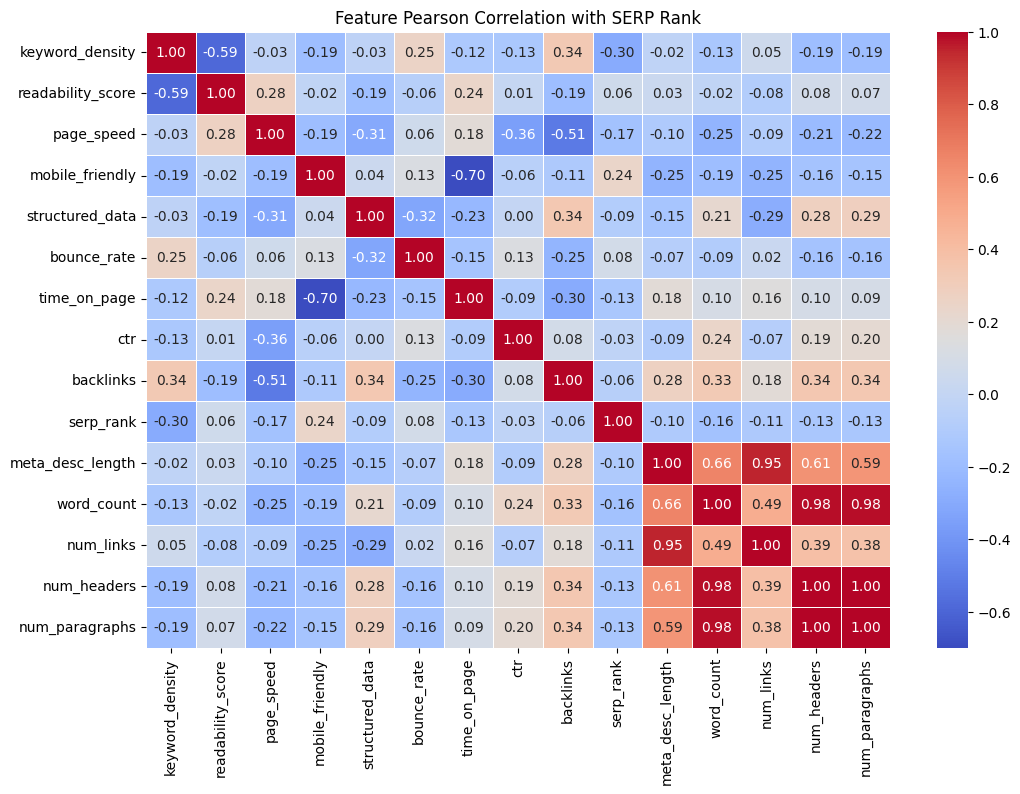

In [ ]:
# Choose type of Correlation, Options - 'pearson' or 'spearman'
correlationMethod = 'pearson'

# Compute correlation matrix (excluding non-numeric columns)
correlation_matrix = serp_df.drop(columns=["page_title", "html_content", "spacy_embedding", "target_search"]).corr(method=correlationMethod)

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Feature {correlationMethod.capitalize()} Correlation with SERP Rank")
plt.show()

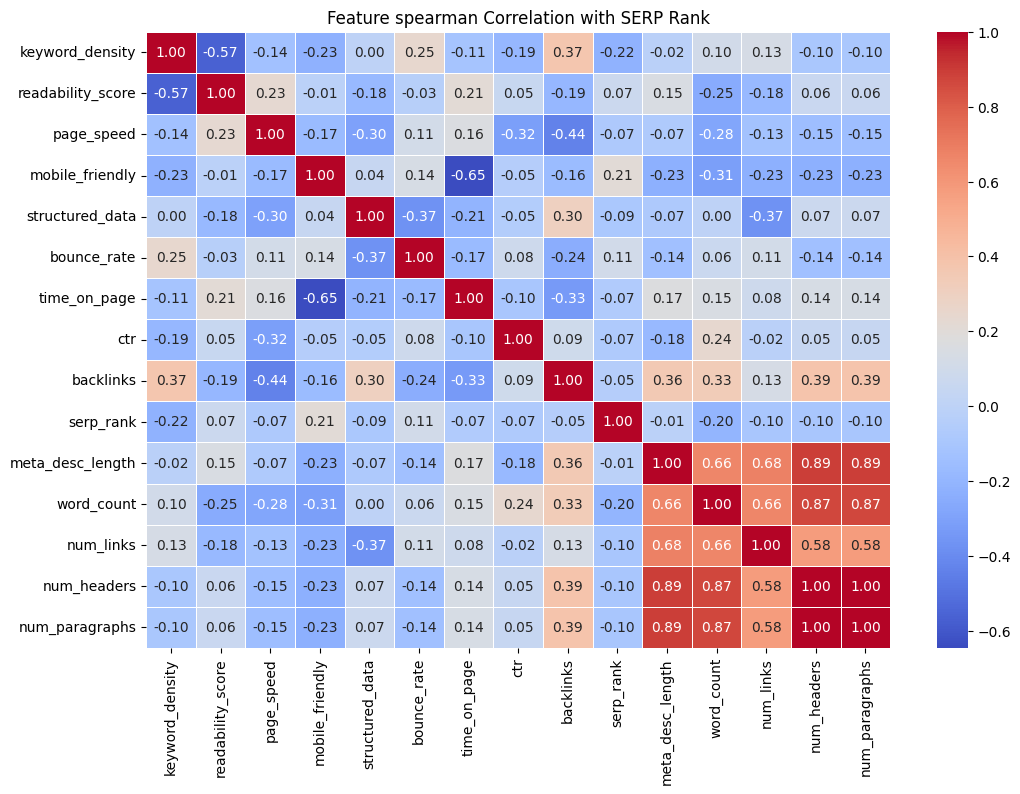

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (excluding non-numeric columns)
correlation_matrix = serp_df.drop(columns=["page_title", "html_content", "spacy_embedding", "target_search"]).corr(method='spearman')

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature spearman Correlation with SERP Rank")
plt.show()




* Negative Correlation (Good):
Features like CTR, backlinks, and time-on-page often improve rankings, leading to lower serp_rank values.

* Positive Correlation (Bad):
Features like bounce rate might worsen rankings, leading to higher serp_rank values.


* Remember: A decrease in serp_rank (closer to rank 1) is a positive outcome in the context of SEO. MEANING  it's a Negative Correlation (aim for -1 or -0.8). I.E CTR vs SERP-rank show in blue a -1.0 strong negative correlation.

### Identify important features affecting SERP ranking

Note 1:
* Handling Multicollinearity:
Some features might be highly correlated with each other (e.g., word count & keyword density).
This can lead to redundancy, causing instability in linear models. By removing one of the correlated features, we can improve model performance.
* Transforming Features Based on Correlation
If we find that a feature has a non-linear correlation (e.g., CTR and rank follow a logarithmic pattern), we can apply transformations like log, sqrt, or polynomial terms to improve regression model accuracy.
  

NOTE 2:
* We don’t just look for negative numbers. We COULD look for the strongest correlations (regardless of sign). would I rather pick 0.3 than -0.04 because the co-relation is stronger?

In [ ]:
#Option one: Look for important features no matter their sign but STRONG relationships

correlation_with_strong_relationships_rank = serp_df.drop(columns=["page_title", "html_content", "spacy_embedding", "target_search"]).corr(method='pearson')["serp_rank"].abs()

# Set a threshold for selecting important features (e.g., |correlation| > 0.2)
threshold = 0.1
important_features = correlation_with_strong_relationships_rank[correlation_with_strong_relationships_rank > threshold].index.tolist()

# Remove 'Rank' since it's the target variable
if "serp_rank" in important_features:
    important_features.remove("serp_rank")

# Print the selected important features
print("Selected Important Features for SERP Ranking:", important_features)


Selected Important Features for SERP Ranking: ['keyword_density', 'page_speed', 'mobile_friendly', 'time_on_page', 'meta_desc_length', 'word_count', 'num_links', 'num_headers', 'num_paragraphs']


In [ ]:
print(important_features)

['keyword_density', 'page_speed', 'mobile_friendly', 'time_on_page', 'meta_desc_length', 'word_count', 'num_links', 'num_headers', 'num_paragraphs']


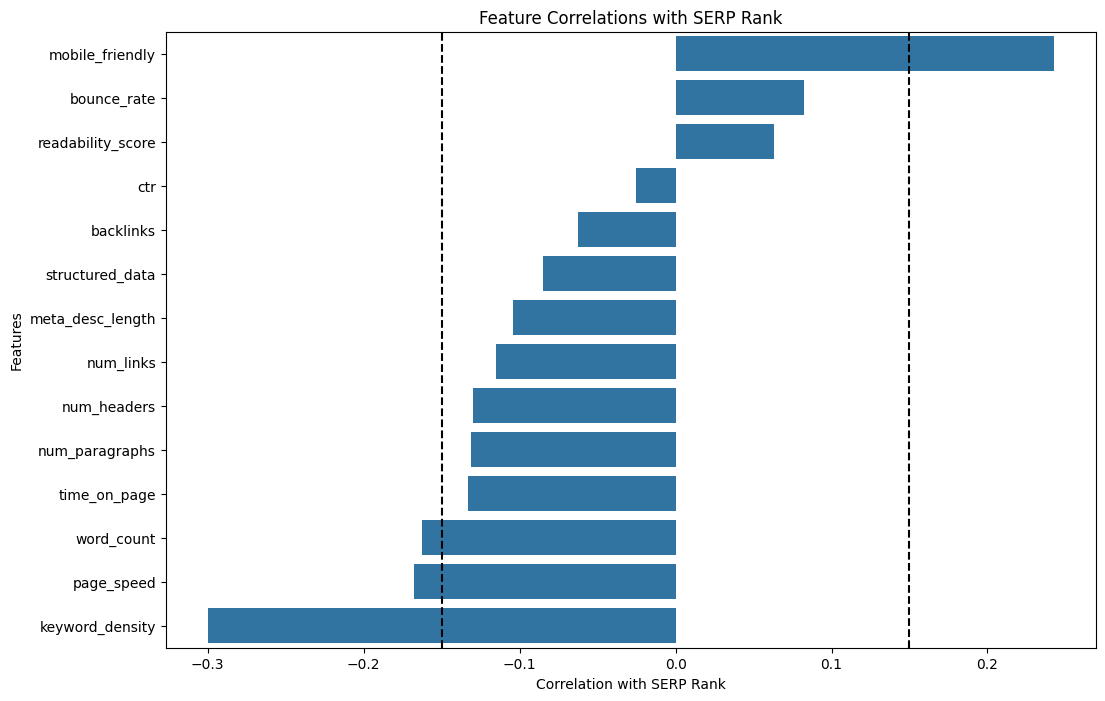

Features that improve ranking: ['keyword_density']
Features that worsen ranking: ['mobile_friendly', 'serp_rank']


'\nif the feature is negatively correlated, dsnt it mean the higher (negatively) it is, it boosts the rank more?\n'

In [ ]:
#Option two: Look for important features but care for their direction (sign)
correlation_with_rank = serp_df.drop(columns=["page_title", "html_content", "spacy_embedding", "target_search"]).corr(method='pearson')["serp_rank"]


# By sorting, the SERP Rank feature which is fully correlated with itself becomes the zero-th feature
sorted_rank_corr = correlation_with_rank.sort_values(ascending=False)

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
# we plot 1 onwards to avoid the SERP rank (index 0) from showing up
sns.barplot(x=sorted_rank_corr.values[1:], y=sorted_rank_corr.index[1:])
plt.xlabel("Correlation with SERP Rank")
plt.ylabel("Features")
plt.title("Feature Correlations with SERP Rank")
plt.axvline(x=0.15, color='black', linestyle='dashed', linewidth=1.5)
plt.axvline(x=-0.15, color='black', linestyle='dashed', linewidth=1.5)
plt.show()

# Define separate thresholds for positive and negative correlations
negative_threshold = -0.2  # Strong negative correlation (ranking booster)
positive_threshold = 0.2   # Strong positive correlation (ranking detractor)

# Select features that strongly improve rankings
ranking_boosters = correlation_with_rank[correlation_with_rank < negative_threshold].index.tolist()

# Select features that strongly worsen rankings
ranking_detractors = correlation_with_rank[correlation_with_rank > positive_threshold].index.tolist()

# Print results
print("Features that improve ranking:", ranking_boosters)
print("Features that worsen ranking:", ranking_detractors)

'''
if the feature is negatively correlated, dsnt it mean the higher (negatively) it is, it boosts the rank more?

--- As per the dummy data, mobile freindly has postive correlation, which means its a rank diminishing factor, however in practice its a rank increasing factor
-- As per interpretation, for features with negative correlation (beyond threshold), the goal is to make them more negative as possible
-- For now, as per interpretation, for features with positive correlation (beyond threshold), lets try to make them more positive as possible (to be verified with data)
'''

####HOMEWORK / Decisions to make:
* Do we pick pearson or spearman correlation?
  *  Pearson when relationships are roughly linear
  *  Spearman when relationships are non-linear or ranking-based
  *  Model is linear for now, lets stick with Pearson (Soumo)
* Which threshold is best? (Soumo)
  * Anything greater than absolute(0.1) on real data should be analyzed further
  * If the regression model is linear and sparse, then we can include everything for now
* Do we pick strong relationship no matter if negative or positive?
  * Yes both correlations matter beyond a certain threshold (Soumo)

### Explore feature interations

How two or more features work together to influence SERP ranking.

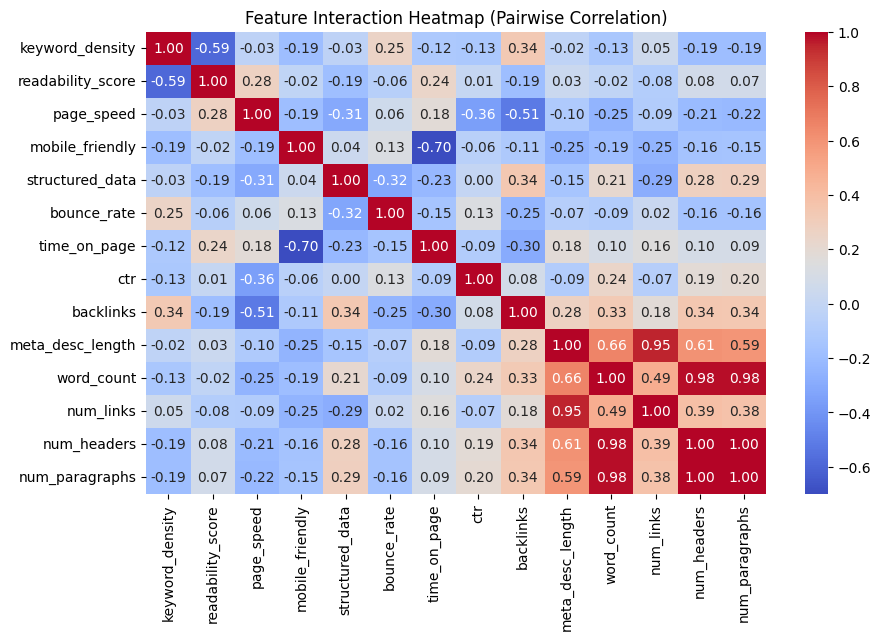

                   keyword_density  readability_score  page_speed  \
keyword_density           1.000000          -0.589734   -0.031893   
readability_score        -0.589734           1.000000    0.275677   
page_speed               -0.031893           0.275677    1.000000   
mobile_friendly          -0.193487          -0.017931   -0.194425   
structured_data          -0.031631          -0.186833   -0.306169   
bounce_rate               0.254500          -0.063268    0.061004   
time_on_page             -0.120427           0.242105    0.180404   
ctr                      -0.127028           0.009306   -0.359505   
backlinks                 0.335939          -0.189127   -0.514426   
meta_desc_length         -0.023996           0.033385   -0.103503   
word_count               -0.134088          -0.022096   -0.249795   
num_links                 0.051147          -0.084581   -0.094933   
num_headers              -0.191454           0.076809   -0.213464   
num_paragraphs           -0.192660

'\nthis plot is already there at top, is there anything new to learn from this one?\n'

In [ ]:
# Compute pairwise feature correlations (excluding Rank)
pairwise_correlation = serp_df.drop(columns=["page_title", "html_content", "spacy_embedding", "target_search"]).corr().drop(index="serp_rank", columns="serp_rank")

# Plot heatmap for feature interactions
plt.figure(figsize=(10, 6))
sns.heatmap(pairwise_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Interaction Heatmap (Pairwise Correlation)")
plt.show()
print(pairwise_correlation)
'''
this plot is already there at top, is there anything new to learn from this one?
'''

###HOMEWORK / Decisions to make:
Next steps from here so we can dig deeping into feature relationships:
* Scatter Plots & Pair Plots to isualize how two features interact with ranking.
  * The Barplot above should be enough to see how strongly features correlate to SERP ranking, we can update thresholds, colors etc later (Soumo)
* Check Polynomial & Multiplicative Interactions toidentify non-linear effects.
* Train an XGBoost Model & Get Feature Importances and see which feature combinations matter most.
  * How about we do both a Boosted Decision Tree model and a Linear Regression model (Soumo)
  * Since our classification labels arent techinically independent entities, rather linear Ranking, I feel a sparse regression model would do better in terms of gaining insights about features and getting it verified (Soumo)



#### Scatter plots

In [ ]:
# # Define feature pairs to analyze
# feature_pairs = [("CTR", "Time_on_Page"), ("Backlinks", "Page_Speed"), ("CTR", "Bounce_Rate")]

# # Plot scatter plots for each feature pair
# for feature_x, feature_y in feature_pairs:
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(x=data[feature_x], y=data[feature_y], hue=data["Rank"], palette="coolwarm")
#     plt.title(f"{feature_x} vs {feature_y} (Colored by Rank)")
#     plt.xlabel(feature_x)
#     plt.ylabel(feature_y)
#     plt.colorbar().set_label("Rank")
#     plt.show()


Polymonial and Multiplcative interations

In [ ]:
# code
# # Create Polynomial and Multiplicative Features
# data["CTR_x_Time_on_Page"] = data["CTR"] * data["Time_on_Page"]
# data["Backlinks_Squared"] = data["Backlinks"] ** 2
# data["Bounce_Rate_x_Page_Speed"] = data["Bounce_Rate"] * data["Page_Speed"]

# # Display new dataset with interaction terms
# print(data[["CTR_x_Time_on_Page", "Backlinks_Squared", "Bounce_Rate_x_Page_Speed"]].head())

'''
Finds the best polynomial transformation of the feature that fits the label.
'''

def best_polynomial_fit(label, feature):

    # Define custom polynomial transformations
    poly_terms = {
        "Linear": lambda x: x,
        "Square": lambda x: x**2,
        "Square Root": lambda x: np.sqrt(np.abs(x) + 1e-5),
        "Log": lambda x: np.log(np.abs(x) + 1e-5),
        "Cubic": lambda x: x**3,
        "Inverse": lambda x: 1 / (x + 1e-5),
        "Exponential": lambda x: np.exp(x / np.max(x))
    }

    results = {}

    for name, func in poly_terms.items():
        try:
            transformed_feature = func(feature)  # Apply transformation

            # Fit linear regression
            model = LinearRegression()
            model.fit(transformed_feature, label)
            predictions = model.predict(transformed_feature)

            # Compute R² score
            r2 = r2_score(label, predictions)
            results[name] = r2  # Store result

        except Exception as e:
            print(f"Skipping {name} due to error: {e}")

    # Sort results by best fit
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

    # Print best transformation
    best_fit = max(sorted_results, key=sorted_results.get)
    print(f"Best transformation: {best_fit} (R² = {sorted_results[best_fit]:.4f})")

    return sorted_results


# We call this function for each feature and store the transformation having best value and use that mode for regression (Soumo)

### (Soumo) @Angel do we need mixed features at this point? Since we are trying out basic regression, lets treat all features as independent entities (sure they can be correlated). If we need to study mixed features, its better to go the shallow neural net route, and let it decide the optimal combination, rather than us brute forcing through various options

####XGBoost model to get feature imporance (i.e. which feature combinations matter most)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

'''
We pass in the polyfactors of the features as found from the section above into the decision tree and sparse regression model
'''

# # Select features (including new interaction terms)
# features = ["CTR", "Backlinks", "Page_Speed", "Time_on_Page", "Bounce_Rate",
#             "CTR_x_Time_on_Page", "Backlinks_Squared", "Bounce_Rate_x_Page_Speed"]
# X = data[features]
# y = data["Rank"]

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train XGBoost model
# xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
# xgb_model.fit(X_train, y_train)

# # Get feature importances
# importances = xgb_model.feature_importances_

# # Display feature importance
# feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
# feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# print(feature_importance_df)

'\nWe pass in the polyfactors of the features as found from the section above into the decision tree and sparse regression model\n'

## Choosing model and weights

 * Regression VS Classification

   * If SERP rank (numerical) has a clear linear or non-linear relationship with several features (like page speed, CTR), then a regression approach makes sense.
   * If features show a more segmented distribution (e.g., top-ranking pages have much higher CTR than lower-ranking ones), a classification approach might be better.

### Regression model

#### Regression Model

Feature 1 Weight: 0.2920
Feature 2 Weight: -0.6184
Feature 3 Weight: -1.5098
Feature 4 Weight: 0.4138
Feature 5 Weight: -0.9150
Actual Ranks: [ 1  2  3  4  5  6  7  8  9 10]
Rounded Predicted Ranks: [3 2 2 5 6 7 7 8 9 6]


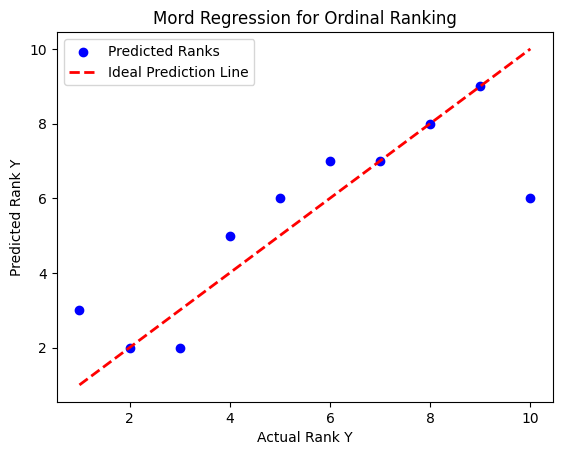

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from mord import LogisticAT
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def fit_regression_model(X, Y, type='linear'): # possible types 'linear', 'l1', 'mord' etc

  # Scale Features (Improves linear regression performance)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  if type == 'linear':
    # Fit Linear Regression Model
    model = LinearRegression()
    model.fit(X_scaled, Y)
  elif type == 'l1':
    # Use Lasso Regression (Sparse Model)
    alpha = 0.1  # Adjust this for more or fewer zero weights
    model = Lasso(alpha=alpha)
    model.fit(X_scaled, Y)
  elif type == 'mord':
    model = LogisticAT()  # Proportional Odds Model
    model.fit(X_scaled, Y)

  # Get Feature Weights (Importance)
  feature_weights = model.coef_
  # Print Model Weights (Coefficient for each feature)
  for i, weight in enumerate(feature_weights):
      print(f"Feature {i+1} Weight: {weight:.4f}")

  # print(f"Intercept: {model.intercept_:.4f}")

  # Predict Ranks
  Y_pred = model.predict(X_scaled)

  Y_pred_rounded = np.round(Y_pred).astype(int)
  print("Actual Ranks:", Y)
  print("Rounded Predicted Ranks:", Y_pred_rounded)

  # Plot Actual vs. Predicted Ranks
  plt.scatter(Y, Y_pred_rounded, color='blue', label="Predicted Ranks")
  plt.plot(Y, Y, color='red', linestyle="dashed", linewidth=2, label="Ideal Prediction Line")
  plt.xlabel("Actual Rank Y")
  plt.ylabel("Predicted Rank Y")
  plt.title(f"{type.capitalize()} Regression for Ordinal Ranking")
  plt.legend()
  plt.show()

# Sample Data: 10 data points with 5 features each
np.random.seed(42)  # For reproducibility
X = np.random.rand(10, 5)  # 10 data points, 5 features
Y = np.arange(1, 11)  # Distinct ordinal ranks from 1 to 10
fit_regression_model(X, Y, type='mord')

### Classification models

#### MLPClassifier

In [ ]:
# todo ensure we pick the right categories
import numpy as np
import pandas as pd

# Define ranking categories
def categorize_rank(rank):
    if rank <= 10:
        return "Top"
    elif rank <= 30:
        return "Mid"
    else:
        return "Low"
data = serp_df.drop(columns=["page_title", "html_content", "spacy_embedding", "target_search"])
# Apply function to create a categorical target variable
data["rank_category"] = data["serp_rank"].apply(categorize_rank)

# Convert categories to numerical labels for MLPClassifier
data["rank_label"] = data["rank_category"].map({"Top": 0, "Mid": 1, "Low": 2})

# Display data sample
print(data[["serp_rank", "rank_category", "rank_label"]].head())


   serp_rank rank_category  rank_label
0         97           Low           2
1          1           Top           0
2         19           Mid           1
3          2           Top           0
4         53           Low           2


In [ ]:
# @to-do pick the actual features for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# "page_title": [f"Page {i}" for i in range(num_samples)],
#     "keyword_density": np.random.uniform(0.5, 5.0, num_samples),  # Percentage of keywords in content
#     "readability_score": np.random.uniform(30, 90, num_samples),  # Flesch-Kincaid readability score
#     "page_speed": np.random.uniform(1, 5, num_samples),  # Load time in seconds
#     "mobile_friendly": np.random.choice([0, 1], num_samples),  # 0 = No, 1 = Yes
#     "structured_data": np.random.choice([0, 1], num_samples),  # 0 = No, 1 = Yes
#     "bounce_rate": np.random.uniform(10, 90, num_samples),  # Percentage of users leaving quickly
#     "time_on_page": np.random.uniform(10, 300, num_samples),  # Time in seconds
#     "ctr": np.random.uniform(0.01, 0.3, num_samples),  # Click-through rate
#     "backlinks": np.random.randint(0, 1000, num_samples),  # Number of backlinks
#     "serp_rank": np.random.randint(1, 100, num_samples),  # SERP rank position
#     "target_search": 'Best universities'  # SERP rank position
# Define features & labels

selected_features = ["mobile_friendly", "structured_data", "bounce_rate", "time_on_page", "backlinks"]
X = data[selected_features]  # Input features
y = data["rank_label"]  # Classification labels

# Split data into train & test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #  stratify=y to ensure balanced category distribution.

# Scale the features for better MLP performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
#ReLU activation for better non-linearity handling.
#Adam optimizer for adaptive learning.
# Runs for 500 iterations (tunable).

from sklearn.neural_network import MLPClassifier

# Initialize MLPClassifier (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Display training results
print("Model trained successfully!")


Model trained successfully!


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#how's the performance

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict categories for test set
y_pred = mlp_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Model Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Confusion Matrix:
 [[0 1]
 [0 3]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


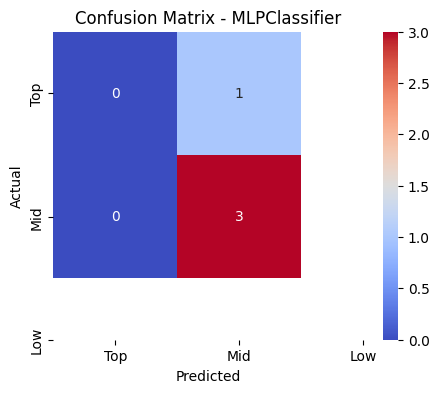

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Top", "Mid", "Low"], yticklabels=["Top", "Mid", "Low"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MLPClassifier")
plt.show()



Model performace badly but that's ok for now

# (Soumo) We will need an ordinal mapping here (both rankings and categories)
Confusion matrix penalizes all mispredictions equally. So a TOP getting misclassified as MID is EQUALLY BAD as TOP getting misclassified as LOW. Which in the ideal scenario should not be.

Same situation will happen in ranking model as well. Rank 1 being mispredicted as Rank 2 is very much ideal, but not rank 5, certainly not rank 10

Put a code below

[[5 1 2]
 [1 5 1]
 [1 1 5]]


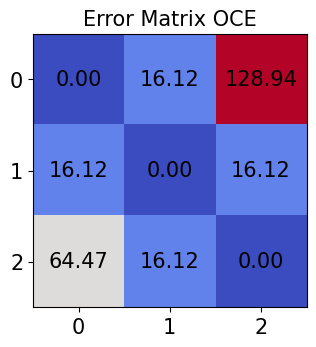

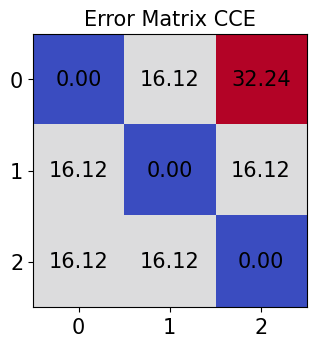

In [ ]:
np.set_printoptions(precision=2, suppress=True)

cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

def oce(y_true, y_pred):
    weights = np.square(np.argmax(y_true) - np.argmax(y_pred))
    err = cce(y_true, y_pred)
    werr = (weights) * err
    return werr

def generate_error_map(conf_mat, loss, name):
    num_class = conf_mat.shape[0]  # confusion matrix is always square, so any dimension would do
    err_mat = np.zeros(conf_mat.shape)

    for i in range(num_class):
        for j in range(num_class):
            count = conf_mat[i,j]
            i_cat = tf.keras.utils.to_categorical(i, num_classes=num_class)
            j_cat = tf.keras.utils.to_categorical(j, num_classes=num_class)
            err = count * loss(i_cat, j_cat)
            err_mat[i,j] = err

    fig1 = plt.figure(figsize=(12,12))
    ax1 = fig1.add_subplot(131)
    ax1.imshow(err_mat, cmap=plt.cm.coolwarm)

    size=15

    for i in range(num_class):
        for j in range(num_class):
            c = err_mat[j,i]
            ax1.text(i, j, f'{c:.2f}', va='center', ha='center', color='black', fontsize=size)

    ax1.set_title('Error Matrix ' + name, fontsize=size)
    ax1.set_xticks(np.arange(0, num_class), [str (num) for num in np.arange(0, num_class)], fontsize=size)
    ax1.set_yticks(np.arange(0, num_class), [str (num) for num in np.arange(0, num_class)], fontsize=size)
    return err_mat

cm = np.asarray([[5, 1, 2], [1, 5, 1], [1, 1, 5]])
print(cm)

err_mat_oce = generate_error_map(cm, oce, 'OCE')
# print('OCE matrix')
# print(err_mat_oce)
err_mat_cce = generate_error_map(cm, cce, 'CCE')

In [ ]:
import numpy as np
import pandas as pd

# Correct column names to match training set
new_sample = pd.DataFrame({
    #"ctr": [0.35],
    "mobile_friendly": [0.8],
    "structured_data": [1],
    "bounce_rate": [45],
    "time_on_page": [150],
    "backlinks": [120],
    #"page_speed": [1800],
})

# selected_features = ["mobile_friendly", "structured_data", "bounce_rate", "time_on_page", "backlinks"]

# Scale the new sample input using the same scaler
new_sample_scaled = scaler.transform(new_sample)

# Predict the rank category
predicted_label = mlp_model.predict(new_sample_scaled)[0]

# Convert prediction to human-readable category
rank_mapping = {0: "Top", 1: "Mid", 2: "Low"}
predicted_category = rank_mapping[predicted_label]

print(f"The model predicts this webpage belongs to the '{predicted_category}' rank category.")


The model predicts this webpage belongs to the 'Mid' rank category.


#### Classification features/categories using embeddings.

Let's assume we want to now generate categories based off embeddings.

In [ ]:
from sklearn.decomposition import PCA

data = serp_df.drop(columns=["spacy_embedding"])


# Select SEO-related features to embed
selected_features = ["mobile_friendly", "structured_data", "bounce_rate", "time_on_page", "backlinks"]
X = data[selected_features]

# Standardize features before applying PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality (embedding size = 3)
pca = PCA(n_components=3)
X_embeddings = pca.fit_transform(X_scaled)

# Convert embeddings to a DataFrame
embedding_df = pd.DataFrame(X_embeddings, columns=["Embed_1", "Embed_2", "Embed_3"])


# create clusters

(Soumo) Dont we want to cluster in original space? In PCA space, sure we might find compression, but we lose all sense of what an original feature is

In [ ]:
from sklearn.cluster import KMeans

# Define number of clusters (3 for Top, Mid, Low rankings)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data["cluster_label"] = kmeans.fit_predict(X_embeddings)

# Convert cluster labels into ranking categories
rank_mapping = {0: "Top", 1: "Mid", 2: "Low"}
data["rank_category"] = data["cluster_label"].map(rank_mapping)

# Display sample clustered data
print(data[["serp_rank", "cluster_label", "rank_category"]].head())


   serp_rank  cluster_label rank_category
0         97              1           Mid
1          1              0           Top
2         19              2           Low
3          2              2           Low
4         53              0           Top


Train MLPClassifer based on clusteers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Prepare dataset for classification
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, data["cluster_label"], test_size=0.2, random_state=42)

# Train MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred = mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"MLP Classifier Accuracy on Clusters: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


MLP Classifier Accuracy on Clusters: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



visualize clusters

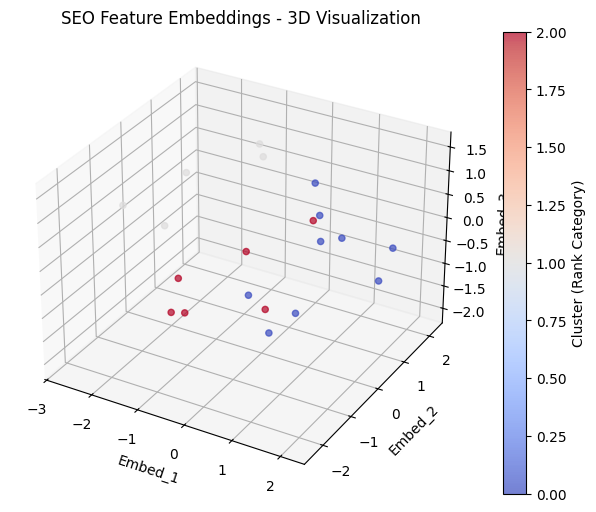

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot of embeddings
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_embeddings[:, 0], X_embeddings[:, 1], X_embeddings[:, 2], c=data["cluster_label"], cmap="coolwarm", alpha=0.7)
ax.set_xlabel("Embed_1")
ax.set_ylabel("Embed_2")
ax.set_zlabel("Embed_3")
plt.colorbar(scatter, label="Cluster (Rank Category)")
plt.title("SEO Feature Embeddings - 3D Visualization")
plt.show()


#### Classification using HTML, titles (text) plus numerical features.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume serp_df contains `spacy_embedding` as a list
data = serp_df.copy()

# Expand `spacy_embedding` into separate columns
embedding_dim = len(data["spacy_embedding"].iloc[0])  # Get embedding size
embedding_cols = [f"Embed_{i}" for i in range(embedding_dim)]

# Convert list embeddings into separate DataFrame columns
embedding_df = pd.DataFrame(data["spacy_embedding"].tolist(), columns=embedding_cols)

# Merge expanded embeddings back into the original dataset
data = pd.concat([data.drop(columns=["spacy_embedding"]), embedding_df], axis=1)

# Select features for PCA (including expanded embeddings)
selected_features = ["mobile_friendly", "structured_data", "bounce_rate", "time_on_page", "backlinks"] + embedding_cols
X = data[selected_features]

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)
X_embeddings = pca.fit_transform(X_scaled)

# Convert PCA embeddings to DataFrame
embedding_pca_df = pd.DataFrame(X_embeddings, columns=["Embed_1", "Embed_2", "Embed_3"])

# Display results
print(embedding_pca_df.head())


     Embed_1    Embed_2    Embed_3
0  16.499490  -0.278778  -1.364196
1  -9.920572   1.766653   3.565413
2  13.685448 -10.844536  -3.051402
3 -14.846645   2.144111 -10.894058
4  -7.674095  -1.990744  10.685938


In [ ]:
# Define 3 clusters for Top, Mid, and Low rankings
kmeans = KMeans(n_clusters=3, random_state=42)
data["cluster_label"] = kmeans.fit_predict(embedding_pca_df)

# Map clusters to rank categories
rank_mapping = {0: "Top", 1: "Mid", 2: "Low"}
data["rank_category"] = data["cluster_label"].map(rank_mapping)

# Display assigned ranking categories
print(data[["cluster_label", "rank_category"]].head())


   cluster_label rank_category
0              2           Low
1              1           Mid
2              0           Top
3              1           Mid
4              1           Mid


In [ ]:
# Prepare dataset for classification
X_train, X_test, y_train, y_test = train_test_split(embedding_pca_df, data["cluster_label"], test_size=0.2, random_state=42)

# Initialize & train MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred = mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"MLP Classifier Accuracy on SEO + NLP Embeddings: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


MLP Classifier Accuracy on SEO + NLP Embeddings: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



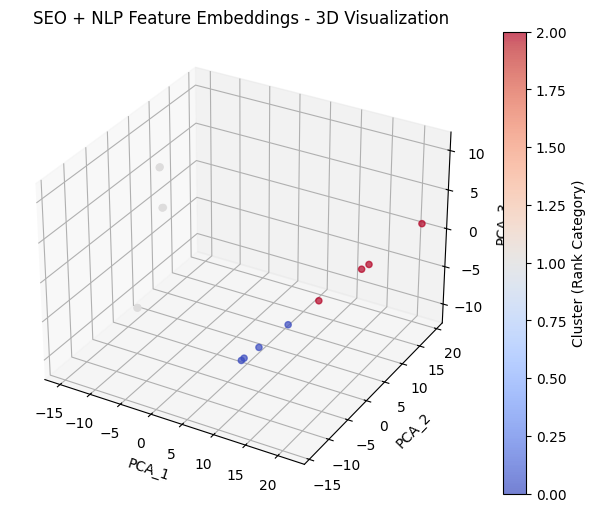

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Convert PCA embeddings into 3D for visualization
pca_3d = PCA(n_components=3)
X_3D = pca_3d.fit_transform(X_scaled)

# Create 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c=data["cluster_label"], cmap="coolwarm", alpha=0.7)
ax.set_xlabel("PCA_1")
ax.set_ylabel("PCA_2")
ax.set_zlabel("PCA_3")
plt.colorbar(scatter, label="Cluster (Rank Category)")
plt.title("SEO + NLP Feature Embeddings - 3D Visualization")
plt.show()


#### Homework / Classification next steps:
* Decide what can be converted into embeddings, is it websites' HTML, titles, keywords, etc?
* Use HDSCan for the clustering
* Use other models for the clasiffication XGBoostClassifier, RandomForestClassifier, LightGBM
* Use OpenAI embeddings (ONCE WE HAVE REAL DATA)